# CTA 1DC background energy distribution


This is my attempt to understand the background event energy distribution for CTA 1DC simulated data.

See https://forge.in2p3.fr/boards/236/topics/1824?r=2057#message-2057

To understand it it's crucial to also look at event offset in the field of view, so we'll do that.

Also, we'll just look at one IRF: South_z20_50h.

(presumably the effects will be very similar for the others as well, left as an exercise for the reader)

In [74]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors

In [85]:
import numpy as np
from astropy.table import Table, vstack
from gammapy.data import DataStore

In [96]:
# Parameters used throughout this notebook
CTADATA = '/Users/deil/work/cta-dc/data/1dc/1dc/'
irf_name = 'South_z20_50h'
n_obs = 10 # Number of observations to use for events
# Histogram binning
energy_bins = 10 ** np.linspace(-2, 2, 100)
offset_bins = np.arange(0, 5, 0.1)

## Actual distribution of events

We load some event data for `South_z20_50h`, select only background events and compute the `n_obs` distribution of observed events in log(energy) and offset bins.

In [97]:
data_store = DataStore.from_dir(CTADATA + 'index/all')
# data_store.info()

In [98]:
mask = data_store.obs_table['IRF'] == irf_name
obs_ids = data_store.obs_table[mask]['OBS_ID'][:n_obs].data

In [99]:
# %%time
# Make one table with all background events (MD_ID == 1)
# only keeping the info we need (DETX, DETY, ENERGY)
tables = []
for obs_id in obs_ids:
    t = data_store.obs(obs_id).events.table
    t = t[t['MC_ID'] == 1]
    t = t[['ENERGY', 'DETX', 'DETY']]
    tables.append(t)

table = vstack(tables, metadata_conflicts='silent')
table['OFFSET'] = np.sqrt(table['DETX'] ** 2 + table['DETY'] ** 2)
print(len(table))

816757


In [100]:
# Compute energy-offset histogram n_obs (number of observed events)
n_obs = np.histogram2d(
    x=table['ENERGY'], y=table['OFFSET'],
    bins=(energy_bins, offset_bins),
)[0]

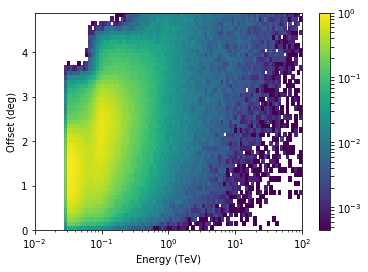

In [101]:
val = n_obs / n_obs.max()
norm = colors.LogNorm()
plt.pcolormesh(energy_bins, offset_bins,  val.T, norm=norm)
plt.semilogx()
plt.colorbar()
plt.xlabel('Energy (TeV)')
plt.ylabel('Offset (deg)')

## Expected distribution from background model

In this section, we load the FITS background model and compute the `n_pred` distribution of number of predicted backgorund events in log(energy) and offset bins (same histogram binning as for `n_obs` above).

In [102]:
from gammapy.data import 
irf_file = CTADATA + '/caldb/data/cta/1dc/bcf/' + irf_name + '/irf_file.fits'
table = Table.read(irf_file, hdu='BACKGROUND')
table
# Columns:
# BGD float32 (21, 36, 36) 1/s/MeV/sr
# ENERG_LO float32        (21,)        TeV
# DETX_LO float32        (36,)        deg
# DETY_LO float32        (36,)        deg

# dety = table['DETY_LO'].data.squeeze()[18]
# print(dety)  # this shows dety == 0.0

# for idx_detx in [18, 21, 22, 23, 24, 25, 26, 27]:
#     detx = table['DETX_LO'].data.squeeze()[idx_detx]
#     energy = table['ENERG_LO'].data.squeeze()
#     bkg = table['BGD'].data.squeeze()[:, idx_detx, 18]
#     val = bkg * energy  # this is to account for equal-width log-energy bins.
#     val /= val.sum()
#     txt = f'offset={detx:.1f}'
#     plt.plot(energy, val, label=txt)


DETX_LO [36],DETX_HI [36],DETY_LO [36],DETY_HI [36],ENERG_LO [21],ENERG_HI [21],"BGD [21,36,36]"
deg,deg,deg,deg,TeV,TeV,1/s/MeV/sr
float32,float32,float32,float32,float32,float32,float32
-6.0 .. 5.66667,-5.66667 .. 6.0,-6.0 .. 5.66667,-5.66667 .. 6.0,0.0125893 .. 125.893,0.0199526 .. 199.526,0.0 .. 0.0


In [46]:
plt.pcolormesh??

## Comparison observed vs predicted

In this section we compare `n_obs` versus `n_pred`.